In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plot
import numpy as np
import git
import os
from git import RemoteProgress
import shutil
import os

In [2]:
os.remove('covid-19-data-master.zip')
os.remove('COVID-19-master.zip')
shutil.rmtree("covid-19-data-master")
shutil.rmtree("COVID-19-master")

In [3]:
from pywget import wget
try:
    link = "https://codeload.github.com/CSSEGISandData/COVID-19/zip/refs/heads/master"
    os.system(str("wget --no-check-certificate --content-disposition " + link))
    links = "https://codeload.github.com/owid/covid-19-data/zip/refs/heads/master"
    os.system(str("wget --no-check-certificate --content-disposition " + links))
except:
    pass

--2021-10-24 12:03:52--  https://codeload.github.com/CSSEGISandData/COVID-19/zip/refs/heads/master
SSL_INIT
Caricato certificato CA "/etc/ssl/certs/ca-certificates.crt"

Risoluzione di codeload.github.com (codeload.github.com)... 140.82.121.9
Connessione a codeload.github.com (codeload.github.com)|140.82.121.9|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: non specificato [application/zip]
Salvataggio in: «COVID-19-master.zip»

     0K .......... .......... .......... .......... .......... 1,28M
    50K .......... .......... .......... .......... .......... 2,19M
   100K .......... .......... .......... .......... .......... 3,45M
   150K .......... .......... .......... .......... .......... 5,82M
   200K .......... .......... .......... .......... .......... 2,34M
   250K .......... .......... .......... .......... .......... 5,16M
   300K .......... .......... .......... .......... .......... 4,47M
   350K .......... .......... .......... ......

In [4]:
shutil.unpack_archive('covid-19-data-master.zip', "covid-19-data-master")
shutil.unpack_archive('COVID-19-master.zip', "COVID-19-master")

In [5]:
dataset = pd.DataFrame(columns = ['Country', 'Rate'])

In [6]:
confirmed = pd.read_csv('COVID-19-master/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('COVID-19-master/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
vaccinations = pd.read_csv('covid-19-data-master/covid-19-data-master/public/data/vaccinations/vaccinations.csv')

In [7]:
confirmed.drop(columns=['Province/State', 'Lat','Long'], inplace=True)
confirmed = confirmed.groupby('Country/Region').sum()
#confirmed.set_index('Country/Region', inplace=True)

deaths.drop(columns=['Province/State', 'Lat','Long'], inplace=True)
deaths = deaths.groupby('Country/Region').sum()
#deaths.set_index('Country/Region', inplace=True)

In [8]:
con=[]
val=[]

for elem in confirmed.index:
    try:
        country    = elem
        
        confirmed.fillna(0, inplace=True)
        confirmed  = confirmed.astype(float)
        confirmed.replace([np.inf, -np.inf], 0, inplace=True)
        #confirmed.T[country].diff().plot(figsize=(15,5))
        
        deaths.fillna(0, inplace=True)
        deaths     = deaths.astype(float)
        deaths.replace([np.inf, -np.inf], 0, inplace=True)
        #deaths.T[country].diff().plot(figsize=(15,5))
        
        death_rate = deaths.T[country].diff()/confirmed.T[country].diff()
        #(deaths.T[country].diff()/confirmed.T[country].diff()).plot(figsize=(15,5))
             
        deathrate = ((death_rate[:223][death_rate[:233].fillna(0)>0]).replace([np.inf, -np.inf], 0).mean())/((death_rate[233:][death_rate[233:].fillna(0)>0]).replace([np.inf, -np.inf], 0).mean())
        
        dataset = dataset.append({'Country': country, 'Rate' : deathrate}, ignore_index=True)
        #con.append(country)
        #val.append(deathrate)
        
    except:
        continue

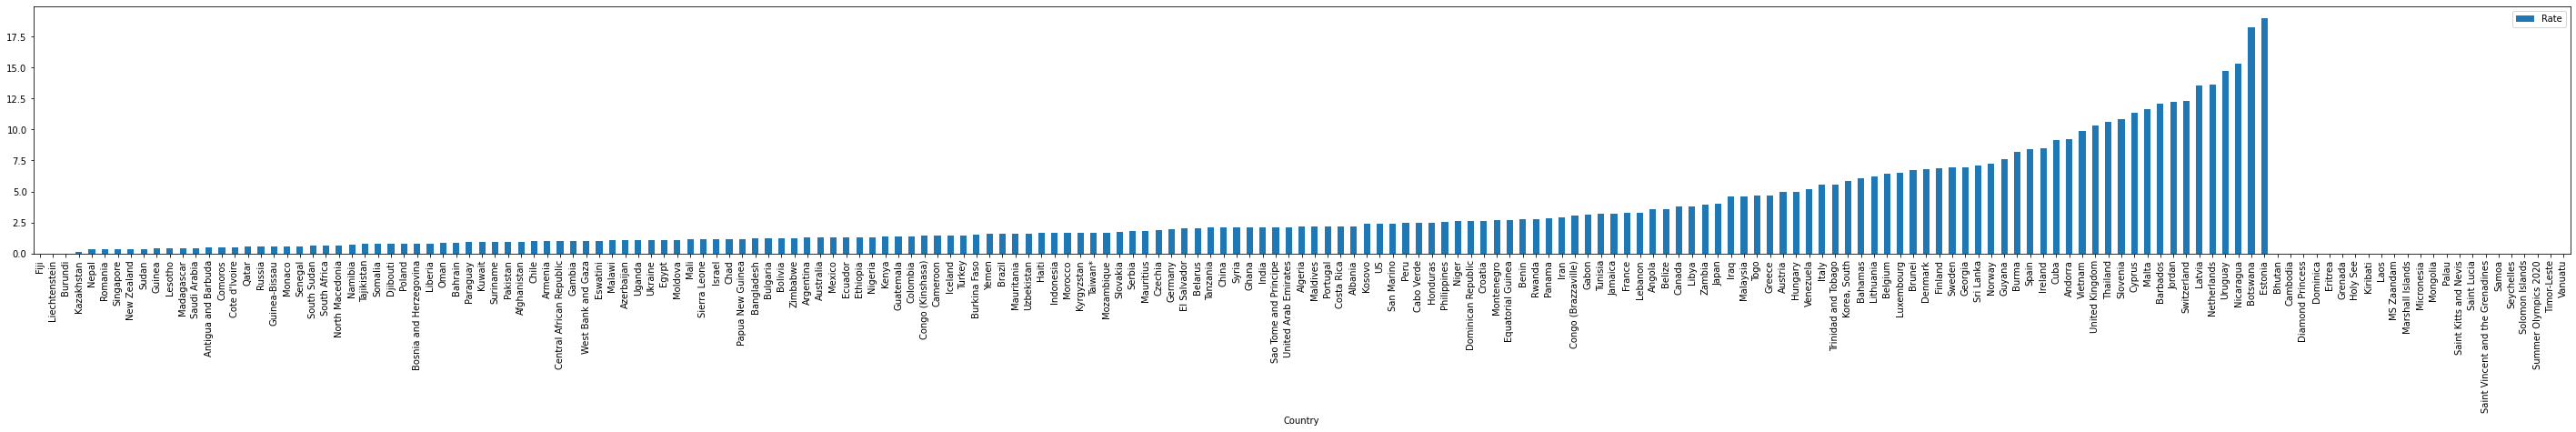

In [65]:
dataset.sort_values(by='Rate').set_index('Country').plot.bar(figsize=(50,5)).get_figure().savefig('Deathrate.svg', bbox_inches='tight')

In [66]:
dataset['Respect'] = (dataset['Rate']/(dataset[dataset['Country']=='Italy']['Rate'].values)-1)*100

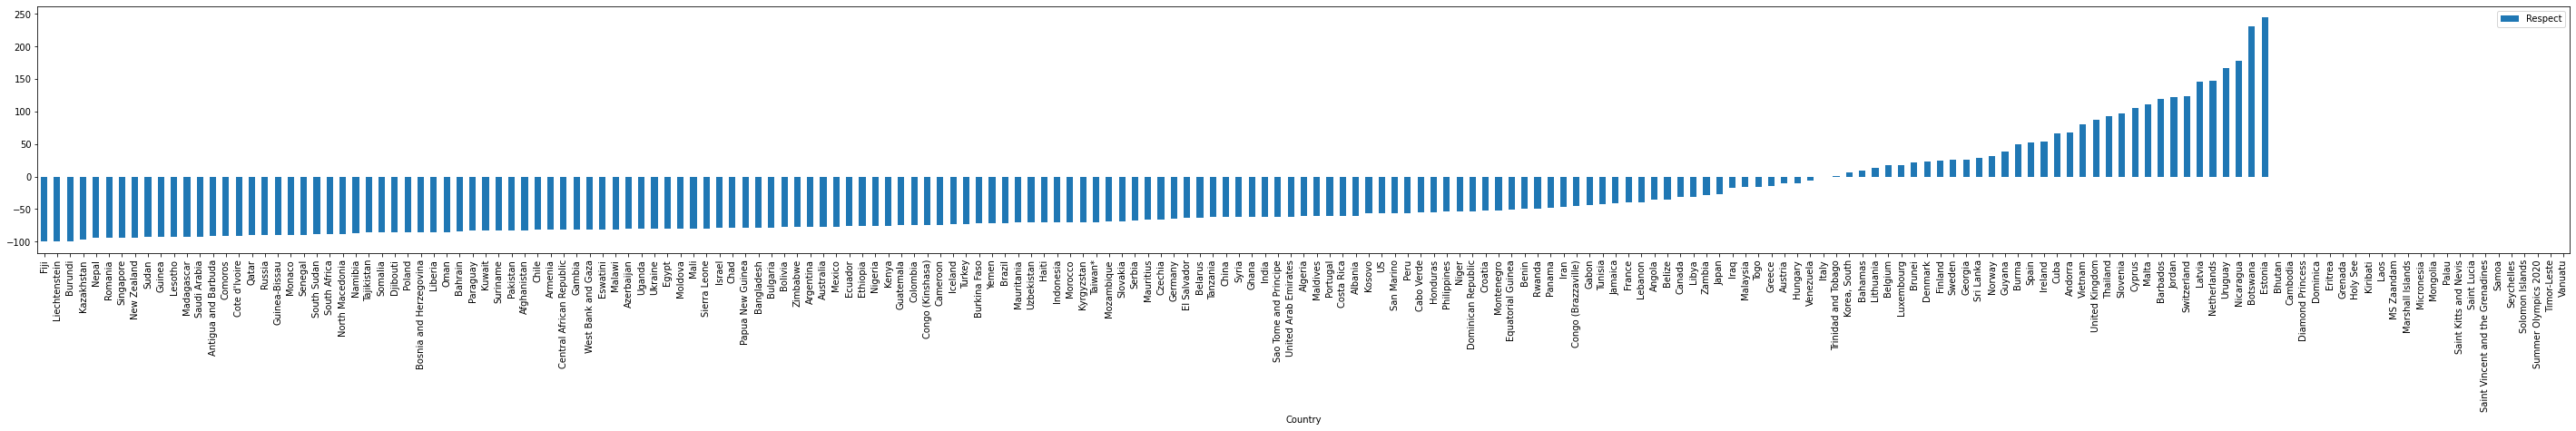

In [67]:
dataset[['Country', 'Respect']].sort_values(by='Respect').set_index('Country').plot.bar(figsize=(50,5)).get_figure().savefig('Deathrate_respect.svg', bbox_inches='tight')

In [9]:
#plot.style.use('fivethirtyeight')

G20 = ["US", "Japan","Germany","United Kingdom","France","Italy","Canada","China","India","Brazil","Korea, South","Russia","Australia","Mexico","Indonesia","Saudi Arabia","Turkey","Argentina","South Africa"]

In [10]:
for country in G20:
    try:
        fig = plot.figure(figsize=(15,5))
        
        confirmed_bets = confirmed.loc[country].dropna().T.diff()
        confirmed_bets.clip(0, inplace=True)
        confirmed_bets.index = pd.to_datetime(confirmed_bets.index)
        deaths_bets = deaths.loc[country].dropna().T.diff()
        deaths_bets.clip(0, inplace=True)
        deaths_bets.index = pd.to_datetime(deaths_bets.index)
        vaccination_data = vaccinations[vaccinations['location']==country][['date', 'people_vaccinated_per_hundred']].set_index('date').dropna()
        vaccination_data.index = pd.to_datetime(vaccination_data.index)
        
        ax1 = fig.add_subplot(111)
        line1 = ax1.plot(confirmed_bets.index, confirmed_bets.values)
        ax2 = ax1.twinx()
        line2 = ax2.plot(deaths_bets.index, deaths_bets.values, color="red")
        ax3 = ax1.twinx()
        ax3.spines.right.set_position(("axes", 1.05))
        line3 = ax3.plot(vaccination_data.index, vaccination_data.values, color="green")
        
        #ax1.xaxis.set_ticks(confirmed[confirmed>0].loc[country].dropna().T.index)
        #plot.legend((line1, line2), ('Function y1', 'Function y2'))
        
        plot.tight_layout()
        
        plot.savefig(str(country) + '_PosvsDeaths.png', bbox_inches='tight')
        plot.close()
    except Exception as e:
        print(e)        
        plot.close()
        continue